In [1]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

In [2]:
#@title Installs
!pip install -U sentence-transformers


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
#@title Imports

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


import sklearn as sk
import os
import nltk
from nltk.data import find
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import wordnet


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
#@title Global tunable parameters

# Base path to store trained snapshot and results
BASE_PATH = 'drive/MyDrive/MIDS-266/w266/project'

# Utility library

In [5]:
#@title Utility print function

def print_version(library_name):
    try:
        lib = __import__(library_name)
        version = getattr(lib, '__version__', 'Version number not found')
        print(f"{library_name} version: {version}")
    except ImportError:
        print(f"{library_name} not installed.")
    except Exception as e:
        print(f"An error occurred: {e}")

#confirm versions
print_version('numpy')
print_version('pandas')
print_version('sklearn')

numpy version: 1.25.2
pandas version: 2.0.3
sklearn version: 1.3.2


In [6]:
#@title Utility Plot Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

In [33]:

def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            lemma_tolower = lemma.name().lower() # convert to lowercase
            lemma_to_lower = lemma_tolower.replace('_', ' ') # remove all underscore characters used as bridge between words
            if lemma_tolower != word: # some lemma words are same as the word being searches, ignore them
              if lemma_tolower not in synonyms:
                #print(lemma_to_lower)
                synonyms.append(lemma_to_lower)
    return set(synonyms)



Synonyms of 'depression': {'clinical depression', 'natural depression', 'great depression', 'slump', 'impression', 'low', 'imprint', 'economic crisis', 'depressive disorder'}


In [ ]:
# Test get_synonyms
# Example usage
word = "depression"
synonyms = get_synonyms(word)
print(f"Synonyms of '{word}': {synonyms}")

# Dataset preparation

In [15]:
#@title Glean class-name and id information into globals
rdt_trainfile = f'{BASE_PATH}/Reddit/both_train.csv'
rdt_train = pd.read_csv(rdt_trainfile)
mh_cls_names = list(rdt_train.class_name.unique())
mh_cls_id = list(rdt_train.class_id.unique())

mh_dict_id_to_name = {}
mh_dict_name_to_id = {}
for idx, value in enumerate(mh_cls_id):
    mh_dict_id_to_name[value] = mh_cls_names[idx]
for idx, value in enumerate(mh_cls_names):
    mh_dict_name_to_id[value] = mh_cls_id[idx]

In [16]:
#@title Read mismatch dataset into a global dataframe
mismatches_file = f'{BASE_PATH}/saved_models/1/mismatches.csv'
res_df = pd.read_csv(mismatches_file)
res_df.head()


,actual,predicted,test_id,text,prob_adhd,prob_anxiety,prob_bipolar,prob_depression,prob_ptsd,prob_none
0,anxiety,anxiety,0,my anxiety when i first wake up everyday is so...,0.002891,0.984900,0.003966,0.001135,0.006954,0.000155
1,adhd,adhd,1,this scene has played out what seems like hund...,0.986308,0.008029,0.003829,0.000898,0.000577,0.000358
2,bipolar,bipolar,2,i'm not sure where to even begin really. i've ...,0.001414,0.000540,0.975988,0.003801,0.017755,0.000503
3,adhd,adhd,3,there's a lot of stuff out there talking about...,0.999771,0.000068,0.000112,0.000012,0.000013,0.000024
4,bipolar,bipolar,4,i can't get motivated to do *anything* but at ...,0.002241,0.000523,0.993125,0.000632,0.003267,0.000212


In [17]:
#@title Inspect the result dataframe
errs = res_df[(res_df['actual'] == 'bipolar') & (res_df['predicted'] != 'bipolar') ]
errs

,actual,predicted,test_id,text,prob_adhd,prob_anxiety,prob_bipolar,prob_depression,prob_ptsd,prob_none
86,bipolar,none,86,so about a week ago my wife and i moved back f...,0.023410,0.172781,0.216575,0.033007,0.062461,0.491766
94,bipolar,anxiety,94,she's still an infant and i'm already worried ...,0.023308,0.776973,0.056504,0.104915,0.036729,0.001571
104,bipolar,adhd,104,a little while ago i made a post where i was w...,0.528845,0.001414,0.467626,0.000461,0.001424,0.000230
128,bipolar,depression,128,"you are climbing a mountain, it's hell, you wa...",0.027794,0.368086,0.130851,0.409512,0.049272,0.014485
158,bipolar,adhd,158,lately i've been having this issue with how ti...,0.610497,0.276737,0.054130,0.005100,0.045156,0.008380
...,...,...,...,...,...,...,...,...,...,...
1330,bipolar,anxiety,1330,i am really struggling to be a good wifu and m...,0.259024,0.509249,0.186720,0.014476,0.026436,0.004094
1339,bipolar,anxiety,1339,"i've been feeling needy and ignored lately, th...",0.023323,0.437934,0.124759,0.007793,0.404314,0.001878
1349,bipolar,anxiety,1349,"well lady... i run off to different countries,...",0.014141,0.797631,0.088776,0.046924,0.048405,0.004121
1393,bipolar,depression,1393,i live in south texas. the weather here is alw...,0.010876,0.033751,0.085253,0.805962,0.015987,0.048170


## Inspect patterns in the post - part 1
Check if the class name string of each class-id is present in the posts. If so, what percentage of the posts have these strings associated with the true class. This will give an idea of the influence of these words on the ability of the NN to predict correctly.

In [55]:
def count_classname_string_in_df (df, mh_cls_names):
  occurance_of_matched_actual_classname_in_text = 0
  total_matches = 0

  for true_class in mh_cls_names:
    valids = df[(df['actual'] == true_class) & (df['predicted'] == true_class) ]
    if true_class == 'none':
      continue
    print(f'Matches for string {true_class} in true class {true_class} : {len(valids)}')
    total_matches += len(valids)
    for index, row in valids.iterrows():
      actual_class = row['actual']
      text = row['text']
      if actual_class in text:
        occurance_of_matched_actual_classname_in_text += 1

  return total_matches, occurance_of_matched_actual_classname_in_text

In [56]:
#@title Occurence of class-name string matching the actual class in test dataset

total_matches, occurances = count_classname_string_in_df(res_df, mh_cls_names)

print(f'\nTotal Matches                             : {total_matches}')
print()
print(f'Occurance of string matching (actual) classname in posts  : {occurances}')
print(f'Percentage of string matching (actual) classname in posts : {occurances/total_matches*100}')


Matches for string adhd in true class adhd : 184
Matches for string depression in true class depression : 160
Matches for string ptsd in true class ptsd : 197
Matches for string anxiety in true class anxiety : 198
Matches for string bipolar in true class bipolar : 186

Total Matches                             : 925

Occurance of string matching (actual) classname in posts  : 453
Percentage of string matching (actual) classname in posts : 48.972972972972975


Observation: Roughly 49% of the test dataset have the class-names appear in the corresponding posts. And the ratio of appearance seems almost uniform across all class types.


In [44]:
#@title Occurence of class-name string matching the actual class in train dataset

train_df = pd.DataFrame()
train_df['actual'] = rdt_train['class_name']
train_df['text'] = rdt_train['post']
train_df['predicted'] = rdt_train['class_name']

total_matches, occurances = count_classname_string_in_df(train_df, mh_cls_names)

print(f'\nTotal Matches                             : {total_matches}')
print()
print(f'Occurance of string matching (actual) classname in posts  : {occurances}')
print(f'Percentage of string matching (actual) classname in posts : {occurances/total_matches*100}')


Matches for string adhd in true class adhd : 2465
Matches for string depression in true class depression : 2450
Matches for string ptsd in true class ptsd : 2001
Matches for string anxiety in true class anxiety : 2422
Matches for string bipolar in true class bipolar : 2407

Total Matches                             : 11745

Occurance of string matching (actual) classname in posts  : 4914
Percentage of string matching (actual) classname in posts : 41.839080459770116


Observation: Roughly 42% of the training dataset has the class-names appear in the corresponding posts. And the ratio of appearance seems almost uniform across all class types.


## Inspect patterns in the post - part 2
Check if synonyms of a class name string is present in the posts. If so, what percentage of the posts have these strings in the (right) actual class. This will give an idea of the influence of these words on the ability of the NN to predict correctly.

In [50]:
def count_classname_synonym_in_df (df, mh_cls_names):
  occurance_of_actual_classname_synonym = 0
  total_matches = 0
  synonym_list = []

  for true_class in mh_cls_names:
    valids = df[(df['actual'] == true_class) & (df['predicted'] == true_class)]
    if true_class == 'none':
      continue
    print(f'Matches for string {true_class} in true class {true_class} : {len(valids)}')
    total_matches += len(valids)

    for index, row in valids.iterrows():
      actual_class = row['actual']
      text = row['text']
      syn = list(get_synonyms(actual_class))
      #print(f'synonym list of {actual_class} : {syn}')
      if any(word in text for word in syn):
        if word == actual_class:
          continue
        occurance_of_actual_classname_synonym += 1
        print(f'{word} found in text for {actual_class}')

  return total_matches, occurance_of_actual_classname_synonym


In [51]:
#@title Occurence of class-name synonyms matching the actual class in test dataset

total_matches, occurances = count_classname_synonym_in_df(res_df, mh_cls_names)

print(f'\nTotal Matches                             : {total_matches}')
print()
print(f'Occurance of synonyms (actual) classname in posts  : {occurances}')
print(f'Percentage of synonyms (actual) classname in posts : {occurances/total_matches*100}')


Matches for string adhd in true class adhd : 184
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd

Observation: Only 3.5% of the test dataset have synonyms present in the right class.

In [57]:
#@title Occurence of class-name synonyms matching the actual class in train dataset

train_df = pd.DataFrame()
train_df['actual'] = rdt_train['class_name']
train_df['text'] = rdt_train['post']
train_df['predicted'] = rdt_train['class_name']

total_matches, occurances = count_classname_synonym_in_df(train_df, mh_cls_names)

print(f'\nTotal Matches                             : {total_matches}')
print()
print(f'Occurance of synonyms in (actual) classname in training dataset  : {occurances}')
print(f'Percentage of synonyms in (actual) classname in training dataset : {occurances/total_matches*100}')


Matches for string adhd in true class adhd : 2465
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adhd
depression found in text for adh

Observation: Only 3.5% of the synonyms appear in the post of the actual class

## Inspects patterns in the post - part 3
Check if class name string is present in the posts. If so, what percentage of the posts have these strings in the (wrong) predicted class. This will give an idea of the influence of these words on the ability of the NN to predict correctly.

In [25]:
#@title Presence of mismatched class-name in misclassified posts of test dataset
occurance_of_mismatched_predicted_classname_in_text = 0
total_mismatches = 0
for true_class in mh_cls_names:
  errs = res_df[(res_df['actual'] == true_class) & (res_df['predicted'] != true_class) ]
  if true_class == 'none':
    continue
  print(f'Predicted class string found in Mismatch for true class {true_class:<20} : {len(errs)}')
  total_mismatches += len(errs)
  for index, row in errs.iterrows():
    predicted_class = row['predicted']
    text = row['text']
    if predicted_class in text:
      #print(f'mismatched classname {predicted_class} seen in text')
      occurance_of_mismatched_predicted_classname_in_text += 1

print(f'\nTotal mismatches                             : {total_mismatches}')
print()
print(f'Occurance of mismatched (predicted) classname  : {occurance_of_mismatched_predicted_classname_in_text}')
print(f'Percentage of mismatched (predicted) classname : {occurance_of_mismatched_predicted_classname_in_text/total_mismatches*100}')


Predicted class string found in Mismatch for true class adhd                 : 64
Predicted class string found in Mismatch for true class depression           : 88
Predicted class string found in Mismatch for true class ptsd                 : 51
Predicted class string found in Mismatch for true class anxiety              : 50
Predicted class string found in Mismatch for true class bipolar              : 62

Total mismatches                             : 315

Occurance of mismatched (predicted) classname  : 43
Percentage of mismatched (predicted) classname : 13.65079365079365


Observation: About 13% of the test dataset have a different class-name string in a misclassifed sample

In [36]:
#@title Presence of mismatched class-synonyms in misclassified posts of test dataset
occurance_of_mismatched_predicted_class_synonym_in_text = 0
total_mismatches = 0
for true_class in mh_cls_names:
  errs = res_df[(res_df['actual'] == true_class) & (res_df['predicted'] != true_class) ]
  if true_class == 'none':
    continue
  print(f'Predicted class string found in Mismatch for true class {true_class:<20} : {len(errs)}')
  total_mismatches += len(errs)
  for index, row in errs.iterrows():
    predicted_class = row['predicted']
    text = row['text']
    if predicted_class in text:
      syn = list(get_synonyms(predicted_class))
      #print(f'synonym list of {predicted_class} : {syn}')
      if any(word in text for word in syn):
        if word == predicted_class:
          continue
        #print(f'mismatched class-synonym {predicted_class} seen in text')
        occurance_of_mismatched_predicted_class_synonym_in_text += 1


print(f'\nTotal mismatches                             : {total_mismatches}')
print()
print(f'Occurance of mismatched (predicted) class synonym  : {occurance_of_mismatched_predicted_class_synonym_in_text}')
print(f'Percentage of mismatched (predicted) class synonym : {occurance_of_mismatched_predicted_class_synonym_in_text/total_mismatches*100}')


Predicted class string found in Mismatch for true class adhd                 : 64
Predicted class string found in Mismatch for true class depression           : 88
Predicted class string found in Mismatch for true class ptsd                 : 51
Predicted class string found in Mismatch for true class anxiety              : 50
Predicted class string found in Mismatch for true class bipolar              : 62

Total mismatches                             : 315

Occurance of mismatched (predicted) class synonym  : 0
Percentage of mismatched (predicted) class synonym : 0.0


Observation: About 0% of the test dataset have synonym of class-name string in a misclassifed sample

In [12]:
# Load https://huggingface.co/sentence-transformers/all-mpnet-base-v2
model = SentenceTransformer("all-mpnet-base-v2", similarity_fn_name="cosine")
embeddings = model.encode([
    errs.text.values[0],
    errs.text.values[1],
    errs.text.values[2],
    errs.text.values[3]
])
similarities = model.similarity(embeddings, embeddings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
similarities

tensor([[1.0000, 0.3619, 0.3349, 0.3430],
        [0.3619, 1.0000, 0.1791, 0.4781],
        [0.3349, 0.1791, 1.0000, 0.2793],
        [0.3430, 0.4781, 0.2793, 1.0000]])

In [14]:
from sentence_transformers import CrossEncoder

model = CrossEncoder("cross-encoder/stsb-roberta-base")
scores = model.predict( [(reference.text.values[0], reference.text.values[1]),
                        (reference.text.values[0], reference.text.values[2]),
                        (reference.text.values[0], errs.text.values[0]),
                        (reference.text.values[0], errs.text.values[1])])
scores

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

array([0.25364584, 0.2666641 , 0.2758621 , 0.26978695], dtype=float32)

In [ ]:
#@title Inspect data and label characteristics

print(f'Training set labels shape: {train_labels.shape}')
print(f'Validation set labels shape: {val_labels.shape}')
print(f'Test set labels shape: {test_labels.shape}')

print(f'Training set examples shape: {train_examples.shape}')
print(f'Validation set examples shape: {val_examples.shape}')
print(f'Test set examples shape: {test_examples.shape}')

print(f'Distribution of the length of all title')
print(rdt_train["title"].str.len().describe())

print('Distribution of the length of all posts')
print(rdt_train["post"].str.len().describe())

print(f'Labels min : {rdt_train.class_id.min()} max : {rdt_train.class_id.max()}')


Training set labels shape: (10981,)
Validation set labels shape: (2746,)
Test set labels shape: (1488,)
Training set examples shape: (10981,)
Validation set examples shape: (2746,)
Test set examples shape: (1488,)
Distribution of the length of all title
count    13727.000000
mean        67.111751
std         48.713468
min          2.000000
25%         34.000000
50%         54.000000
75%         85.000000
max        306.000000
Name: title, dtype: float64
Distribution of the length of all posts
count    13727.000000
mean      1065.297734
std       1373.414370
min        123.000000
25%        362.000000
50%        658.000000
75%       1236.500000
max      38168.000000
Name: post, dtype: float64
Labels min : 0 max : 5


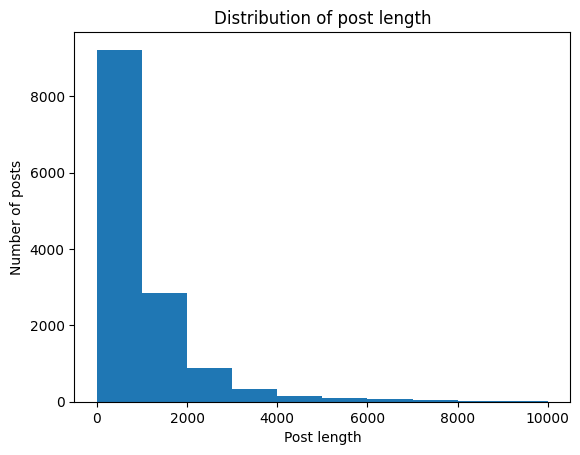

In [ ]:
#@ Histogram of all post length
plt.hist(rdt_train["post"].str.len(), bins=10, range=(0, 10000))
plt.title('Distribution of post length')
plt.xlabel('Post length')
plt.ylabel('Number of posts')
plt.show()

In [ ]:
#@title Distribution of labels in training and test sets
for i in range(np.max(train_labels)):
  pos_indices = np.where(train_labels == i)
  pct_positive = len(pos_indices[0])/len(train_labels)
  print(f'Labels {i} in training set: {len(pos_indices[0])}/{len(train_labels)} ({pct_positive})')

for i in range(np.max(val_labels)):
  pos_indices = np.where(val_labels == i)
  pct_positive = len(pos_indices[0])/len(val_labels)
  print(f'Labels {i} in validation set: {len(pos_indices[0])}/{len(val_labels)} ({pct_positive})')

for i in range(np.max(test_labels)):
  pos_indices = np.where(test_labels == i)
  pct_positive = len(pos_indices[0])/len(test_labels)
  print(f'Labels {i} in test set: {len(pos_indices[0])}/{len(test_labels)} ({pct_positive})')


Labels 0 in training set: 1965/10981 (0.17894545123394956)
Labels 1 in training set: 1958/10981 (0.17830798652217467)
Labels 2 in training set: 1900/10981 (0.17302613605318276)
Labels 3 in training set: 1992/10981 (0.18140424369365268)
Labels 4 in training set: 1589/10981 (0.14470448957289864)
Labels 0 in validation set: 500/2746 (0.1820830298616169)
Labels 1 in validation set: 464/2746 (0.16897305171158047)
Labels 2 in validation set: 507/2746 (0.18463219227967953)
Labels 3 in validation set: 458/2746 (0.16678805535324107)
Labels 4 in validation set: 412/2746 (0.15003641660597233)
Labels 0 in test set: 248/1488 (0.16666666666666666)
Labels 1 in test set: 248/1488 (0.16666666666666666)
Labels 2 in test set: 248/1488 (0.16666666666666666)
Labels 3 in test set: 248/1488 (0.16666666666666666)
Labels 4 in test set: 248/1488 (0.16666666666666666)


In [ ]:
mh_cls_names = list(rdt_train.class_name.unique())
mh_cls_names
mh_cls_id = list(rdt_train.class_id.unique())
mh_cls_id

mh_dict_id_to_name = {}
mh_dict_name_to_id = {}
for idx, value in enumerate(mh_cls_id):
    mh_dict_id_to_name[value] = mh_cls_names[idx]
for idx, value in enumerate(mh_cls_names):
    mh_dict_name_to_id[value] = mh_cls_id[idx]

print(mh_dict_id_to_name)
print(mh_dict_name_to_id)


{5: 'none', 1: 'anxiety', 4: 'ptsd', 3: 'depression', 0: 'adhd', 2: 'bipolar'}
{'none': 5, 'anxiety': 1, 'ptsd': 4, 'depression': 3, 'adhd': 0, 'bipolar': 2}


# Main Control loop

In [11]:
!ls /content/drive/MyDrive/MIDS-266/w266/project/saved_models/


1  2  3
